In [1]:
import matplotlib.pyplot as plt
import matplotlib
import csv
from collections import Counter
from collections import defaultdict
import numpy as np
import matplotlib.ticker as plticker
from matplotlib import colors
import pandas as pd
import datetime as dt

import seaborn as sns
from scipy.stats import pearsonr
from scipy.stats import norm
import uncertainties.unumpy as unp

from patsy import dmatrices
import statsmodels.api as sm

import joypy

In [2]:
hex_codes = [
    "#618669",
    "#4E5E48",
    "#F1C081",
    "#C08A46",
    "#A83B17",
    "#862E19",
    "#62270C"
]

hex_codes.append("#C2A67E")
hex_codes.append("#86B790")

In [3]:

def pearsonr_ci(x,y,alpha=0.05):
    ''' calculate Pearson correlation along with the confidence interval using scipy and numpy
    Parameters
    ----------
    x, y : iterable object such as a list or np.array
      Input for correlation calculation
    alpha : float
      Significance level. 0.05 by default
    Returns
    -------
    r : float
      Pearson's correlation coefficient
    pval : float
      The corresponding p value
    lo, hi : float
      The lower and upper bound of confidence intervals
    '''

    r, p = pearsonr(x,y)
    r_z = np.arctanh(r)
    se = 1/np.sqrt(len(x)-3)
    z = norm.ppf(1-alpha/2)
    lo_z, hi_z = r_z-z*se, r_z+z*se
    lo, hi = np.tanh((lo_z, hi_z))
    return r, p, lo, hi

In [1]:
year_to_month = defaultdict(list)

northeast = ["CT", "NY", "MA", "ME", "NH", "VT", "RI"]

detail_human_cases = ""
detail_horse_cases = ""

with open(detail_human_cases) as f:
    data = csv.DictReader(f)
    for l in data:
        if l['state'] in northeast:
            year = int(l['year'])
            year_to_month[year].append(int(l['month']))
            
with open(detail_horse_cases) as f:
    data = csv.DictReader(f)
    for l in data:
        if l['state'] in northeast:
            year = int(l['year'])
            month = dt.datetime.strptime(l['onsetdate'], "%Y-%m-%d").month
            year_to_month[year].append(month)
        
        
year_to_counts = defaultdict(dict)
for i,j in year_to_month.items():
    year_to_counts[i] = {k:v for k,v in sorted(Counter(j).items())}
    
year_to_counts

NameError: name 'defaultdict' is not defined

In [5]:
year_to_freqs = defaultdict(dict)

months = []
for i in range(1,13):
    months.append(i)


for k,v in year_to_counts.items():
    total = np.sum(list(v.values()))
    for month, count in v.items():
        year_to_freqs[k][month] = round((count/total)*100,2)
        
    for i in months:
        if i not in year_to_freqs[k]:
            year_to_freqs[k][i] = 0
            
    year_to_freqs[k] = {k:v for k,v in sorted(year_to_freqs[k].items())}
        
year_to_freqs = {k:v for k,v in sorted(year_to_freqs.items())}

In [56]:
df_dict = defaultdict(list)
for k,v in year_to_counts.items():
    for month, count in v.items():
        for i in range(count):
            df_dict['year'].append(k)
            df_dict['month'].append(month)
            df_dict['count'].append(count)
        
df = pd.DataFrame(df_dict)

/var/folders/pd/bjtp4xt916vfpszlps7rr5_c0000gn/T/ipykernel_2535/3478980703.py:6: UserWarning: To output multiple subplots, the figure containing the passed axes is being cleared
  joypy.joyplot(df, by="year", column="month", hist=False, ax=ax, colormap=cmap)


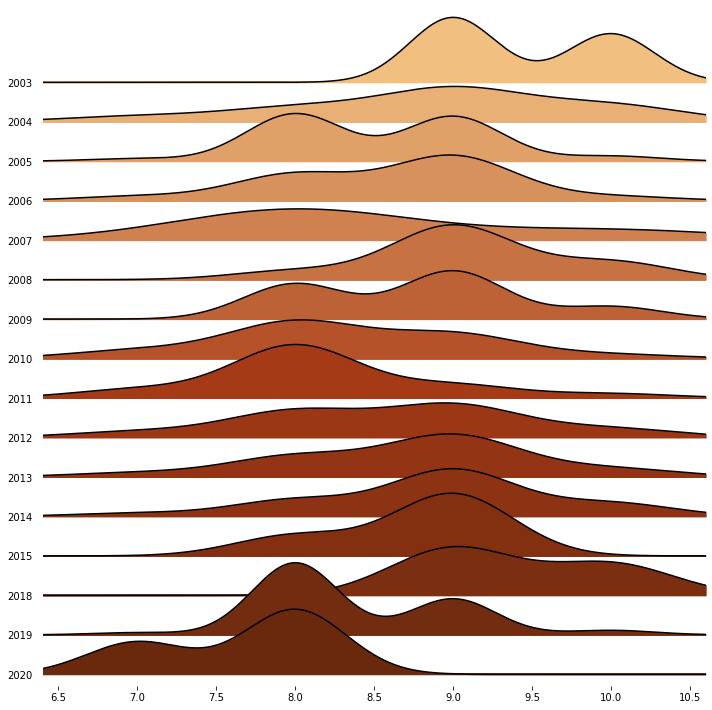

In [66]:
fig, ax = plt.subplots(1,1, figsize=(10,10))

cmap = colors.LinearSegmentedColormap.from_list("", ["#F1C081","#A83B17", "#62270C"],18)
c_list = list(cmap(range(16)))

joypy.joyplot(df, by="year", column="month", hist=False, ax=ax, colormap=cmap)


plt.show()

In [10]:
year_to_median = {}
year_to_mean = {}
year_to_total = {}

for k,v in year_to_month.items():
    year_to_total[k] = len(v)
    year_to_median[k] = np.median(v)
    year_to_mean[k] = np.mean(v)

/Users/verityhill/miniconda3/lib/python3.9/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


gradient = -0.0027276345672075106, intercept = 8.711655077146405
correlation = -0.07688946183331766, p-value = 0.7771552896173792, CI= -0.55157189578869 to 0.43541136130378216


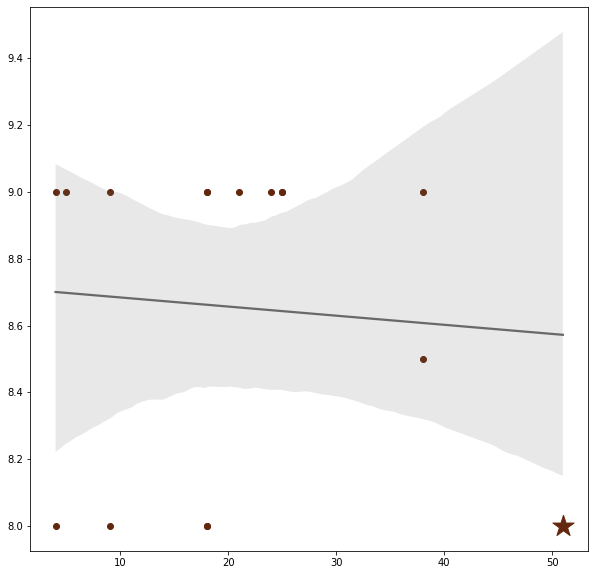

In [70]:
fig, ax = plt.subplots(1,1, figsize=(10,10))

x = []
y = []

for k,v in year_to_total.items():
    x.append(v)
    y.append(year_to_median[k])
    
x_2019 = [year_to_total[2019]]
y_2019 = [year_to_median[2019]]
    
plt.scatter(x,y, color="#62270C")
sns.regplot(x,y, ax=ax, scatter_kws={'s':1}, color="dimgrey", scatter=False)
plt.scatter(x_2019, y_2019, color="#62270C", marker="*", s=500)

m,c = np.polyfit(x, y, 1)
ys = []
for ele in x:
    ys.append((ele*m) + c)
print(f'gradient = {m}, intercept = {c}')
corr,p, lo, hi = pearsonr_ci(x,y)

print(f'correlation = {corr}, p-value = {p}, CI= {lo} to {hi}')


plt.show()

In [15]:
df_dict = defaultdict(list)
for k,v in year_to_total.items():
    df_dict["year"].append(k)
    df_dict["median_month"].append(year_to_median[k])
    df_dict["total"].append(v)
    
df = pd.DataFrame(df_dict)

In [27]:
expr = """median_month ~ total"""

y,x = dmatrices(expr, df, return_type='dataframe')
poisson_results = sm.GLM(y,x, family=sm.families.Poisson()).fit()

print(poisson_results.summary())

                 Generalized Linear Model Regression Results                  
Dep. Variable:           median_month   No. Observations:                   16
Model:                            GLM   Df Residuals:                       14
Model Family:                 Poisson   Df Model:                            1
Link Function:                    Log   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:                -32.307
Date:                Fri, 02 Dec 2022   Deviance:                      0.39057
Time:                        15:54:56   Pearson chi2:                    0.386
No. Iterations:                     3   Pseudo R-squ. (CS):          0.0001435
Covariance Type:            nonrobust                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept      2.1647      0.158     13.681      0.0

In [28]:
predictions = poisson_results.get_prediction(x)
sum_frame = predictions.summary_frame()
predicted_counts = sum_frame['mean']
lower = sum_frame['mean_ci_lower']
upper = sum_frame['mean_ci_upper']

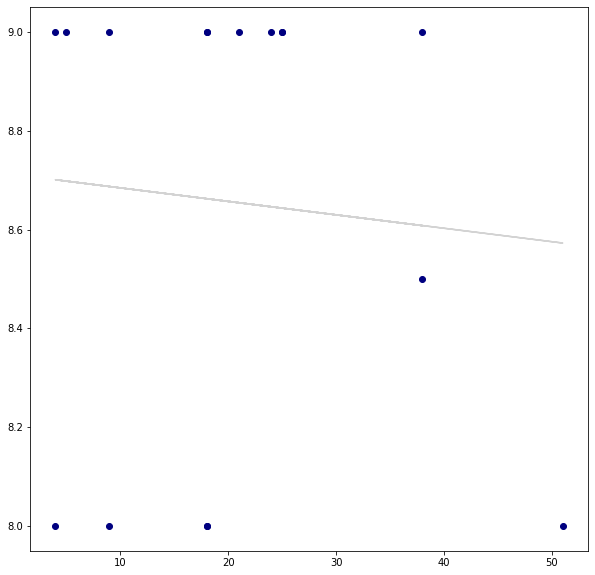

In [32]:
fig, ax = plt.subplots(1,1, figsize=(10,10))

plt.scatter(df['total'],df['median_month'], color="navy")
# plt.scatter(x_2019, y_2019, color="navy", marker="*", s=500)

plt.plot(df['total'],predicted_counts, color="lightgrey")
# plt.fill_between(df['total'],lower, upper, alpha=0.5, color="lightgrey")

# plt.savefig("../../figures/figure_5/infection_rate_case_correlation.pdf", bbox_inches="tight")